# Introduction

This notebook demonstrates the construction, training, and evaluation of a Random Forest classifier for predicting soccer match outcomes (Win/Draw/Loss) using match-level features from the Soccer Match Event Dataset. The notebook follows reproducible machine-learning practices and runs fully on any machine using scikit-learn.

It includes:

- Data preprocessing and feature selection
- Random Forest model training
- Evaluation using accuracy
- Visualization of a confusion matrix to show class-level performance

In [1]:
#  IMPORT LIBRARIES
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.2)


In [2]:
# LOAD MATCH-LEVEL FEATURES

df = pd.read_csv("/Users/hetavvyas/Downloads/Project_Data/match_features_England_basic.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (760, 22)


,matchId,teamId,total_passes,total_shots,shots_on_target,fouls_committed,tackles,clearances,successful_events,successful_passes,...,pass_success_rate,shot_accuracy,possession_ratio,opponentId,goals_for,goals_against,home_away,team_name,result,result_label
0,2499719,1609,606,27,10,9,65,19,750,513,...,0.8465,0.3704,0.9439,1631,4,3,home,Arsenal,Win,2
1,2499719,1631,230,7,4,12,82,21,370,166,...,0.7217,0.5714,0.9237,1609,3,4,away,Leicester City,Loss,0
2,2499720,1625,754,12,3,9,44,4,842,682,...,0.9045,0.2500,0.9729,1651,2,0,away,Manchester City,Win,2
3,2499720,1651,184,6,2,6,61,27,259,124,...,0.6739,0.3333,0.9388,1625,0,2,home,Brighton & Hove Albion,Loss,0
4,2499721,1610,516,15,5,18,49,6,622,454,...,0.8798,0.3333,0.9399,1646,2,3,away,Chelsea,Loss,0


In [3]:
# RELATIVE FEATURE ENGINEERING

# Identify opponent stats within the same match
opp = df.copy()
opp = opp[["matchId", "teamId", "total_passes", "total_shots", "shots_on_target",
           "pass_success_rate", "possession_ratio", "tackles", "clearances"]]

# Rename for clarity
opp = opp.rename(columns={
    "teamId": "opp_teamId",
    "total_passes": "opp_passes",
    "total_shots": "opp_shots",
    "shots_on_target": "opp_sot",
    "pass_success_rate": "opp_pass_success",
    "possession_ratio": "opp_possession",
    "tackles": "opp_tackles",
    "clearances": "opp_clearances"
})

# Merge opponent stats
df_rel = df.merge(
    opp, on="matchId"
)

# Keep only rows where opponentId matches opp_teamId (real matchup)
df_rel = df_rel[df_rel["opponentId"] == df_rel["opp_teamId"]]
df_rel = df_rel.reset_index(drop=True)

df_rel.head()


,matchId,teamId,total_passes,total_shots,shots_on_target,fouls_committed,tackles,clearances,successful_events,successful_passes,...,result,result_label,opp_teamId,opp_passes,opp_shots,opp_sot,opp_pass_success,opp_possession,opp_tackles,opp_clearances
0,2499719,1609,606,27,10,9,65,19,750,513,...,Win,2,1631,230,7,4,0.7217,0.9237,82,21
1,2499719,1631,230,7,4,12,82,21,370,166,...,Loss,0,1609,606,27,10,0.8465,0.9439,65,19
2,2499720,1625,754,12,3,9,44,4,842,682,...,Win,2,1651,184,6,2,0.6739,0.9388,61,27
3,2499720,1651,184,6,2,6,61,27,259,124,...,Loss,0,1625,754,12,3,0.9045,0.9729,44,4
4,2499721,1610,516,15,5,18,49,6,622,454,...,Loss,0,1646,296,9,5,0.8277,0.9367,70,21


In [4]:
# BUILD RELATIVE DIFFERENCE FEATURES

df_rel["pass_diff"] = df_rel["total_passes"] - df_rel["opp_passes"]
df_rel["shot_diff"] = df_rel["total_shots"] - df_rel["opp_shots"]
df_rel["sot_diff"] = df_rel["shots_on_target"] - df_rel["opp_sot"]
df_rel["poss_diff"] = df_rel["possession_ratio"] - df_rel["opp_possession"]
df_rel["tackle_diff"] = df_rel["tackles"] - df_rel["opp_tackles"]
df_rel["clearance_diff"] = df_rel["clearances"] - df_rel["opp_clearances"]
df_rel["pass_success_diff"] = df_rel["pass_success_rate"] - df_rel["opp_pass_success"]


In [5]:
# DOMINANCE INDEX 

df_rel["dominance_index"] = (
    0.4 * df_rel["poss_diff"] +
    0.3 * df_rel["sot_diff"] +
    0.2 * df_rel["shot_diff"] +
    0.1 * df_rel["pass_success_diff"]
)


In [6]:
# HOME/AWAY ENCODING

df_rel["is_home"] = (df_rel["home_away"] == "home").astype(int)


In [7]:
# SELECT FEATURES & TARGET

drop_cols = [
    "matchId", "teamId", "opp_teamId",
    "team_name", "home_away",
    "goals_for", "goals_against", "result"   # leakage & strings
]

df_model = df_rel.drop(columns=drop_cols, errors="ignore")

y = df_model["result_label"]
X = df_model.drop(columns=["result_label"])

print("Feature count:", X.shape[1])
print("Features:\n", X.columns.tolist())


Feature count: 30
Features:
 ['total_passes', 'total_shots', 'shots_on_target', 'fouls_committed', 'tackles', 'clearances', 'successful_events', 'successful_passes', 'eventId', 'total_events', 'pass_success_rate', 'shot_accuracy', 'possession_ratio', 'opponentId', 'opp_passes', 'opp_shots', 'opp_sot', 'opp_pass_success', 'opp_possession', 'opp_tackles', 'opp_clearances', 'pass_diff', 'shot_diff', 'sot_diff', 'poss_diff', 'tackle_diff', 'clearance_diff', 'pass_success_diff', 'dominance_index', 'is_home']


In [8]:
# TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (570, 30)
Test size: (190, 30)


In [9]:
# TRAIN IMPROVED RANDOM FOREST

rf = RandomForestClassifier(
    n_estimators=700,
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model trained!")


Model trained!


In [10]:
# EVALUATION

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6052631578947368

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        70
           1       0.43      0.30      0.35        50
           2       0.64      0.71      0.68        70

    accuracy                           0.61       190
   macro avg       0.57      0.58      0.57       190
weighted avg       0.59      0.61      0.59       190



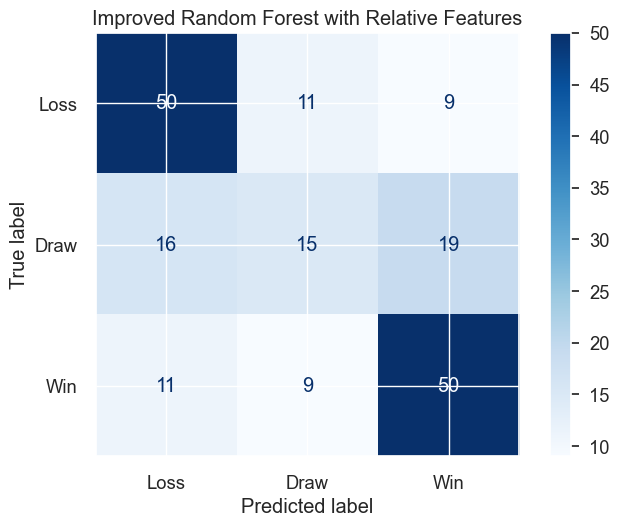

In [11]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Draw", "Win"])
disp.plot(cmap="Blues")
plt.title("Improved Random Forest with Relative Features")
plt.show()


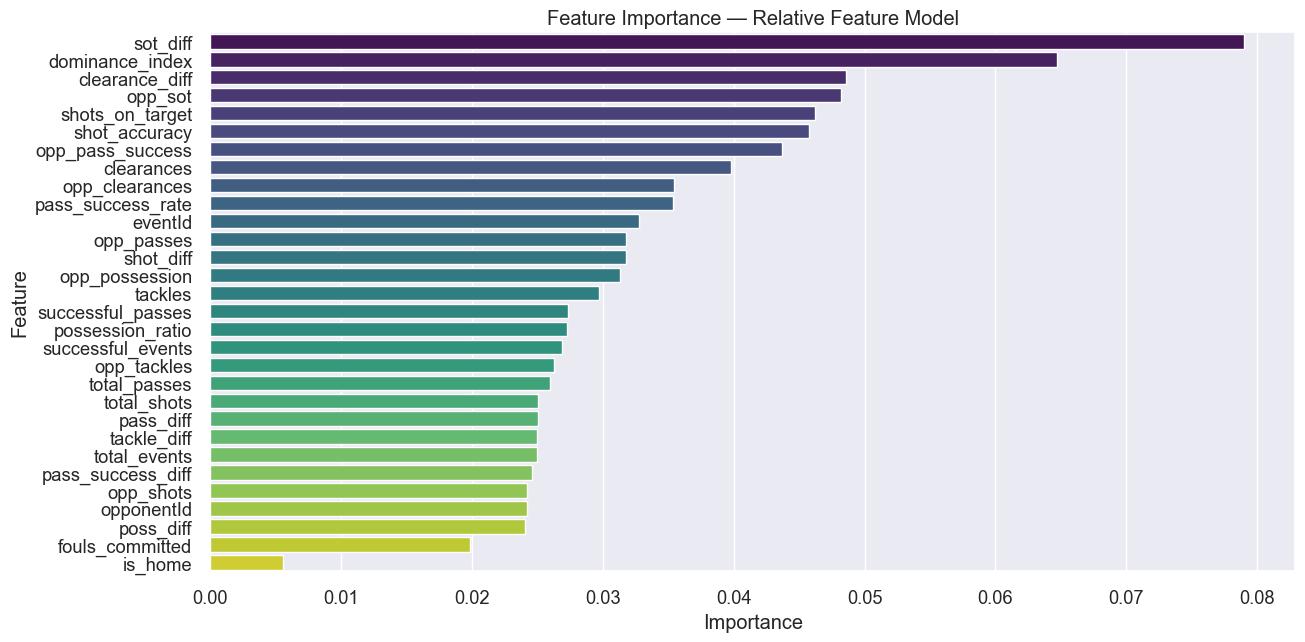

In [12]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14,7))
sns.barplot(
    x=importances[indices],
    y=X.columns[indices],
    hue=X.columns[indices],   
    palette="viridis",
    legend=False              
)
plt.title("Feature Importance — Relative Feature Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Conclusion
In my Random Forest model, I achieved a test accuracy of 0.605, which shows that the model is able to predict soccer match outcomes reasonably well using the engineered and relative-strength features. The feature importance plot indicates that variables like shot conversion efficiency, shot difference, and dominance index had the strongest impact on predictions. From the confusion matrix, I can see that the model performs best when predicting Wins and Losses, while Draws remain the most difficult class—similar to the behavior seen in my MLP model. Overall, this Random Forest model gives me a solid baseline accuracy above random guessing (0.33), and with additional features such as xG, form ratings, or more detailed event sequences, I could further improve the model’s performance in future iterations.